# Guide Dog Classifier: Model Building with Frozen EfficientNet-B3  
## Objectives:

- Load pre-partitioned dataset (2,800 images: 1,008 train, 112 val, 280 test per class)
- Set up EfficientNet-B3 with frozen layers and a custom classifier
- Apply data augmentation to improve generalization
- Train and evaluate (accuracy, precision, recall, F1)
- Profile VRAM usage to ensure 4GB compatibility
- Reset cache for efficiency

## Why Freeze Layers?

Freezing EfficientNet-B3’s feature extractor reduces memory and compute demands, as only the custom classifier is trained. This is ideal for a 4GB GPU, keeping VRAM usage low while leveraging pre-trained features for transfer learning.

Let’s get started!

# Importing necessary libraries

In [1]:
# Core Python and system utilities
import os
import time

# Numerical and data handling
import numpy as np

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# Progress tracking
from tqdm import tqdm


# reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Verify CUDA, Define Paths

In [2]:
# CUDA check and setup
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    torch.cuda.empty_cache()  # Clear any residual memory
    torch.backends.cudnn.benchmark = False  # Disable for deterministic results
    torch.backends.cudnn.enabled = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Initial VRAM Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Initial VRAM Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
else:
    device = torch.device("cpu")
    print("Using CPU. Performance may be slow.")

# Define dataset paths
dataset_root = "./dataset"
train_path = os.path.join(dataset_root, "train")
val_path = os.path.join(dataset_root, "val")
test_path = os.path.join(dataset_root, "test")

CUDA Available: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Initial VRAM Allocated: 0.00 MB
Initial VRAM Reserved: 0.00 MB


# DataLoader (No Transforms Yet)

In [3]:
# Load datasets using ImageFolder 
train_dataset = datasets.ImageFolder(train_path)
val_dataset = datasets.ImageFolder(val_path)
test_dataset = datasets.ImageFolder(test_path)

# Create DataLoaders
batch_size = 64
num_workers = 2  # number of subprocesses
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Verify dataset sizes and classes
try:
    assert len(train_dataset.classes) == 2, "Expected 2 classes: guide_dogs, non_guide_dogs"
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes: {train_dataset.classes}")
except AssertionError as e:
    print(f"Dataset Error: {e}")
    raise
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Train samples: 2016
Validation samples: 224
Test samples: 572
Classes: ['guide_dogs', 'non_guide_dogs']


# verifiying our model performance without modification

## load the model and set up transforms 

In [4]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(device)

# Get the transforms from the model weights 
transform = models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()
# Apply transforms to datasets
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform


# Guide dog breeds in ImageNet class label format
guide_dog_indexes = [235, 207, 208, 232, 245, 236, 248, 247, 279]


In [5]:
# Evaluation function
def evaluate_split(split_path, dataset, model, device):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    guide_dog_class_index = dataset.class_to_idx["guide_dogs"]
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc=f"Evaluating {os.path.basename(split_path)}"):
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i in range(len(preds)):
                predicted_idx = preds[i].item()
                is_pred_guide = predicted_idx in guide_dog_indexes
                is_true_guide = labels[i].item() == guide_dog_class_index
                if is_pred_guide == is_true_guide:
                    correct += 1
                total += 1
    accuracy = 100 * correct / total
    print(f"✅ Accuracy on {os.path.basename(split_path)}: {accuracy:.2f}%")
    return accuracy

# Evaluate on all splits
results = {}
for split, dataset in [("train", train_dataset), ("val", val_dataset), ("test", test_dataset)]:
    acc = evaluate_split(os.path.join(dataset_root, split), dataset, model, device)
    results[split] = acc

print("\n📊 Summary:")
for split, acc in results.items():
    print(f"{split}: {acc:.2f}%")

Evaluating train: 100%|███████████████████████████████████| 63/63 [00:21<00:00,  2.93it/s]


✅ Accuracy on train: 69.99%


Evaluating val: 100%|███████████████████████████████████████| 7/7 [00:02<00:00,  3.03it/s]


✅ Accuracy on val: 72.32%


Evaluating test: 100%|████████████████████████████████████| 18/18 [00:05<00:00,  3.23it/s]

✅ Accuracy on test: 71.15%

📊 Summary:
train: 69.99%
val: 72.32%
test: 71.15%


### We Need for Fine-Tuning

## Rationale of for Data augmentation 

Let's explore the default tranforms

In [6]:
transform = models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms() 
print (transform)

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### Quick BreakDown
- crop_size=[300]: Crops image to 300x300 for EfficientNet-B3 input.
- resize_size=[320]: Resizes image to 320x320 before cropping.
- mean=[0.485, 0.456, 0.406]: Subtracts ImageNet mean for RGB normalization.
- std=[0.229, 0.224, 0.225]: Divides by ImageNet std for RGB normalization.
- Interpolation=InterpolationMode.BICUBIC: Uses bicubic interpolation for smooth resizing.

This is an ImgaeClassifier Object 

It ain't necessarily ordered , for example resizing is before cropping not unlike printed here 

## Let's Build our custom transform for Data Augmentation
the Custom transform is applied only for training data </br>
the validation and test sets will keep the default transform

In [7]:
# Define custom training transforms
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(300, scale=(0.8, 1.0)),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET), #Applies learned augmentation policies for robustness.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Verifiy shapes

In [8]:
# Verify shapes
train_dataset.transform = train_transform
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Image batch shape: {images.shape}")  # Expected: [batch_size, 3, 300, 300]
print(f"Label batch shape: {labels.shape}")  # Expected: [batch_size]
print(f"Labels: {labels}")
print(f"Sample tensor dimensions: {images[0].shape}")

Image batch shape: torch.Size([64, 3, 300, 300])
Label batch shape: torch.Size([64])
Labels: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])
Sample tensor dimensions: torch.Size([3, 300, 300])


## Setting Up EfficientNet-B3 with Frozen Layers  
We load the pre-trained EfficientNet-B3, freeze its feature extractor, and replace the classifier head with a binary output layer.

Let’s set up the model.

In [9]:
# Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

the freezing goal here is to focus only to train the new classifier before fine tuning the model as a whole

### let's see the classifier that we want to update

In [10]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)


here we conclude that the input layer of the classfier is of size 1536

In [11]:
#Replace classifier for binary classification
model.classifier = nn.Sequential(
    nn.Linear(1536, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
)
model = model.to(device)  # Ensure model is on GPU
print(model.classifier)

Sequential(
  (0): Linear(in_features=1536, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=1, bias=True)
)


### Verify freeze

In [12]:
for idx, param in enumerate(model.parameters()):
    print(f"({idx}, {param.requires_grad})", end=' ')

(0, False) (1, False) (2, False) (3, False) (4, False) (5, False) (6, False) (7, False) (8, False) (9, False) (10, False) (11, False) (12, False) (13, False) (14, False) (15, False) (16, False) (17, False) (18, False) (19, False) (20, False) (21, False) (22, False) (23, False) (24, False) (25, False) (26, False) (27, False) (28, False) (29, False) (30, False) (31, False) (32, False) (33, False) (34, False) (35, False) (36, False) (37, False) (38, False) (39, False) (40, False) (41, False) (42, False) (43, False) (44, False) (45, False) (46, False) (47, False) (48, False) (49, False) (50, False) (51, False) (52, False) (53, False) (54, False) (55, False) (56, False) (57, False) (58, False) (59, False) (60, False) (61, False) (62, False) (63, False) (64, False) (65, False) (66, False) (67, False) (68, False) (69, False) (70, False) (71, False) (72, False) (73, False) (74, False) (75, False) (76, False) (77, False) (78, False) (79, False) (80, False) (81, False) (82, False) (83, False) (8

In [13]:
!nvidia-smi

Thu May 29 18:18:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              6W /   60W |    1471MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Training Setup

We train the custom classifier (frozen convolutional layers) for 20 epochs, using:
- **Loss**: Binary Cross-Entropy (`BCEWithLogitsLoss`).
- **Optimizer**: Adam with learning rate 0.001.
- **Metrics**: Accuracy, precision, recall, F1-score on validation set.
- **Batch Size**: 64 .

We’ll track training and validation loss/accuracy to monitor performance.
you can change the number of epochs if you want 
10 epochs is a fair choice 

In [14]:
## BCE
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []
        
        for data, target in train_loader:
            data, target = data.to(device), target.float().to(device).view(-1, 1)  # Float targets, shape (batch_size, 1)
            optimizer.zero_grad()
            output = model(data)  # Output: (batch_size, 1) logits
            loss = criterion(output, target)  # BCEWithLogitsLoss
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            # Apply sigmoid for predictions
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()  # Threshold at 0.5
            train_preds.extend(preds.cpu().numpy().flatten())
            train_targets.extend(target.cpu().numpy().flatten())

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.float().to(device).view(-1, 1)
                output = model(data)  # (batch_size, 1) logits
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)

                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                val_preds.extend(preds.cpu().numpy().flatten())
                val_targets.extend(target.cpu().numpy().flatten())

        # Metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        val_acc = accuracy_score(val_targets, val_preds)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
   # Clear memory after epoch
    
    return history

In [15]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10: Train Loss: 0.5133, Train Acc: 0.7431, Val Loss: 0.3724, Val Acc: 0.8438
Epoch 2/10: Train Loss: 0.4038, Train Acc: 0.8145, Val Loss: 0.3461, Val Acc: 0.8661
Epoch 3/10: Train Loss: 0.3535, Train Acc: 0.8353, Val Loss: 0.3314, Val Acc: 0.8616
Epoch 4/10: Train Loss: 0.2904, Train Acc: 0.8676, Val Loss: 0.3409, Val Acc: 0.8661
Epoch 5/10: Train Loss: 0.3009, Train Acc: 0.8671, Val Loss: 0.3274, Val Acc: 0.8750
Epoch 6/10: Train Loss: 0.2678, Train Acc: 0.8750, Val Loss: 0.3201, Val Acc: 0.8929
Epoch 7/10: Train Loss: 0.2744, Train Acc: 0.8829, Val Loss: 0.3333, Val Acc: 0.8884
Epoch 8/10: Train Loss: 0.2487, Train Acc: 0.8919, Val Loss: 0.3221, Val Acc: 0.8839
Epoch 9/10: Train Loss: 0.2266, Train Acc: 0.9028, Val Loss: 0.3305, Val Acc: 0.8929
Epoch 10/10: Train Loss: 0.2122, Train Acc: 0.9082, Val Loss: 0.3328, Val Acc: 0.8929


## Evaluation and Visualization

We evaluate the model on the test set (560 images) and report:
- Accuracy
- Precision, Recall, F1-score
- Confusion Matrix

We also visualize training/validation loss and accuracy to assess performance.

In [16]:
# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.float().to(device).view(-1, 1)
            output = torch.sigmoid(model(data))
            preds.extend((output > 0.5).float().cpu().numpy().flatten())
            targets.extend(target.cpu().numpy().flatten())
    
    acc = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average="binary")
    return acc, precision, recall, f1, preds, targets

# Evaluate
test_acc, test_precision, test_recall, test_f1, test_preds, test_targets = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.8759
Test Precision: 0.8669
Test Recall: 0.8881
Test F1-Score: 0.8774


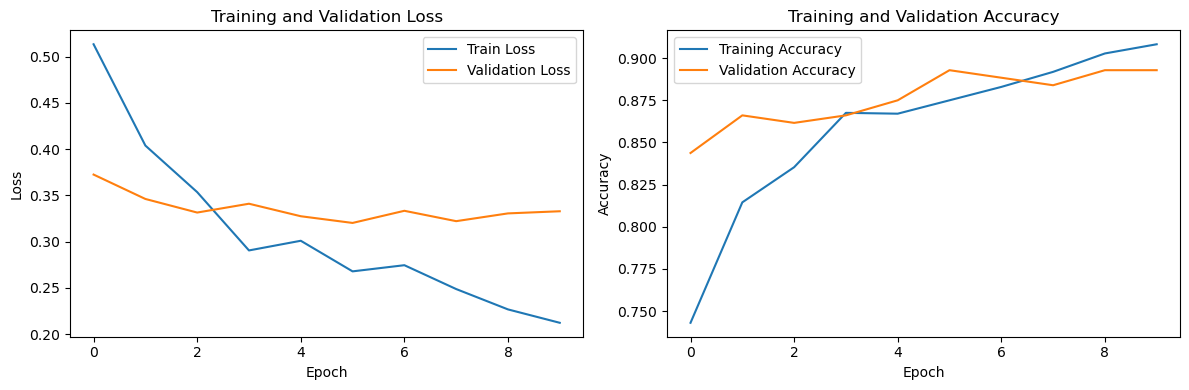

In [17]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

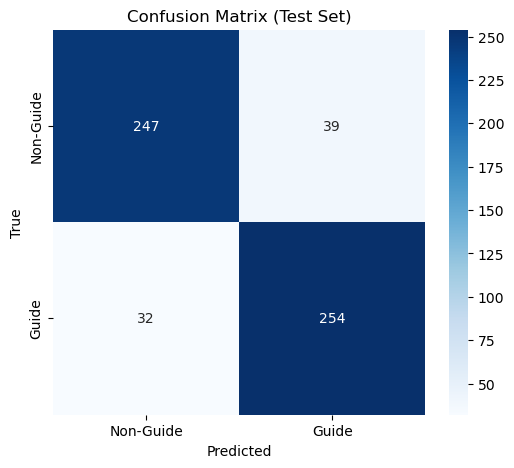

In [18]:
# Confusion matrix
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Guide", "Guide"], yticklabels=["Non-Guide", "Guide"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Memory Profiling with NVIDIA-SMI

We use NVIDIA-SMI to monitor VRAM usage, ensuring training fits within our 4GB RTX 3050 Ti. Freezing VGG16’s convolutional layers minimizes memory needs, as only the classifier parameters (~13M) are trained.

Let’s check GPU memory usage (run in a terminal or below).

In [19]:
!nvidia-smi

Thu May 29 18:23:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              6W /   60W |    3287MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Saving the Model

We save the trained model’s weights for use in later notebooks (e.g., fine-tuning). This snapshot captures the classifier trained with frozen layers.

In [20]:
# Save model
torch.save(model.state_dict(), "./model/frozen_model.pth")
print("Model saved as 'frozen_model.pth'")

Model saved as 'frozen_model.pth'


## Reset Cache and Shut Down Kernel

To ensure a clean state, we clear GPU memory and shut down the kernel. After running the cell below, the kernel will stop. Open `2_Fine_Tuning_No_Optimization.ipynb` in a new Jupyter session.

**Note**: Restart Jupyter or open the next notebook manually after shutdown.

In [21]:
from IPython import get_ipython
import torch

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("GPU memory cleared.")

# Shut down the kernel
get_ipython().kernel.do_shutdown(restart=True)

GPU memory cleared.


{'status': 'ok', 'restart': True}